<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/4.Bike/Bike_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.EDA

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [103]:
from google.colab import drive
drive.mount('/content/gdrive')
train_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/bike_train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/bike_test.csv')
datetime=test_df['datetime']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [104]:
df=pd.concat([train_df,test_df],axis=0,ignore_index=True)
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0


##1)Basic statistics

In [105]:
df.info() #null at casual,registered,count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [106]:
test_df.info() #test_df has no registered,casual data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


##2)Basic feature engineering


In [107]:
df.drop(['holiday','casual','registered'],axis=1,inplace=True) #columns have meanings 

In [108]:
df.datetime=df.datetime.apply(pd.to_datetime) #datetime is a dtype in pandas #lambda is for numbers
df['year']=df.datetime.apply(lambda x:x.year) #each function extracts data from datetime object #names like year,month can't be written in df.year like form
df['month']=df.datetime.apply(lambda x:x.month)
df['hour']=df.datetime.apply(lambda x:x.hour)
df.drop(['datetime'],axis=1,inplace=True)
df.head(3)

,season,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour
0,1,0,1,9.84,14.395,81,0.0,16.0,2011,1,0
1,1,0,1,9.02,13.635,80,0.0,40.0,2011,1,1
2,1,0,1,9.02,13.635,80,0.0,32.0,2011,1,2


##3)Encoding

In [109]:
year=LabelEncoder().fit_transform(df['year'])
df['year']=pd.DataFrame(year)

#2.Preprocessing

##2)Scaling

In [110]:
df.describe() #outlier can be spotted here too

,season,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,191.574132,0.502561,6.537775,11.546752
std,1.106918,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,181.144454,0.500008,3.438776,6.914405
min,1.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,42.000000,0.000000,4.000000,6.000000
50%,3.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,145.000000,1.000000,7.000000,12.000000
75%,3.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,284.000000,1.000000,10.000000,18.000000
max,4.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,977.000000,1.000000,12.000000,23.000000


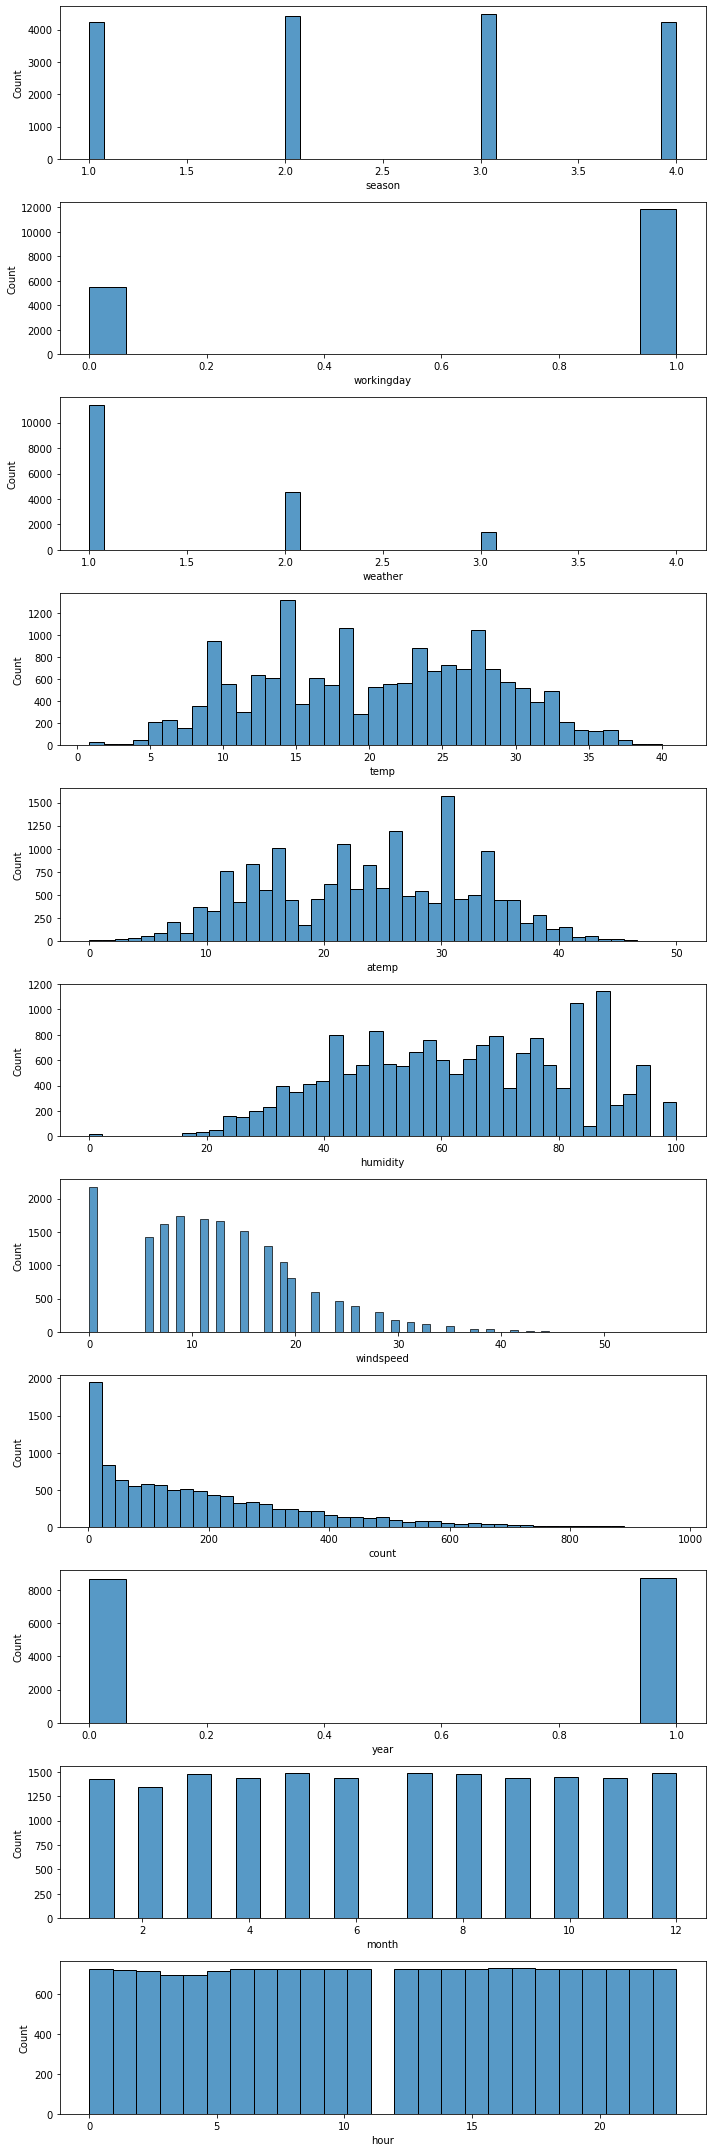

In [111]:
fig=plt.figure(figsize=(10,30)) 
for x,feature in enumerate(df.columns):
  fig.add_subplot(11,1,x+1)
  sns.histplot(data=df,x=feature) #histplot covers countplot
fig.tight_layout()

In [112]:
df['count']=np.log1p(df['count'])
df['windspeed']=np.log1p(df['windspeed'])

##3)Feature selection

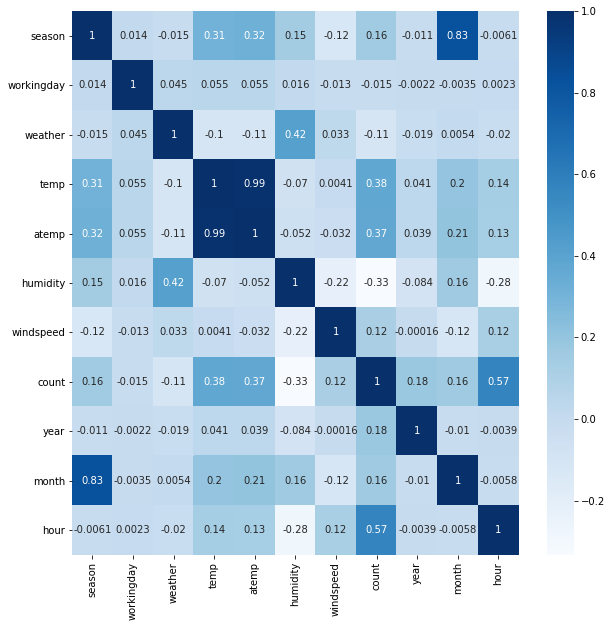

In [113]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='Blues')

In [114]:
df.drop('atemp',axis=1,inplace=True) #corr value of 0.99(lower corr with target among two)

#3.Modeling

In [115]:
train_df=df.loc[df['count'].isna()==False] #comparison with True in condition needs two =
test_df=df.loc[df['count'].isna()==True]
target_df=train_df['count']
feature_df=train_df.drop('count',axis=1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6493 entries, 10886 to 17378
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   workingday  6493 non-null   int64  
 2   weather     6493 non-null   int64  
 3   temp        6493 non-null   float64
 4   humidity    6493 non-null   int64  
 5   windspeed   6493 non-null   float64
 6   count       0 non-null      float64
 7   year        6493 non-null   int64  
 8   month       6493 non-null   int64  
 9   hour        6493 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 558.0 KB


In [116]:
def get_eval(real,pred): #make RMSLE(start from L to R)
  squared_error=(np.log1p(real)-np.log1p(pred))**2
  rmsle=np.sqrt(np.mean(squared_error))
  rmse=np.sqrt(mean_squared_error(real,pred)) #prefer rmse to normal mse
  mae=mean_absolute_error(real,pred)
  print('RMSLE:{0:.4f} / RMSE:{1:.4f} / MAE:{2:.4f}'.format(rmsle,rmse,mae))

In [117]:
X_train,X_test,y_train,y_test=train_test_split(feature_df,target_df,test_size=0.1,random_state=0)

In [118]:
lr_reg=LinearRegression() #Ridge does not provide feature importance
lr_reg.fit(X_train,y_train)
pred=(lr_reg.predict(X_test)) #must after logscaling
get_eval(y_test,np.round(pred)) #target is int

RMSLE:0.2475 / RMSE:1.0922 / MAE:0.8713


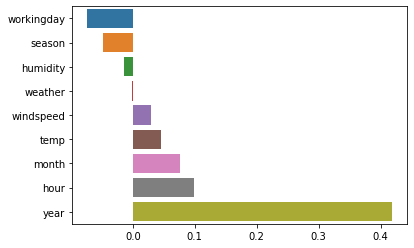

In [119]:
coef=pd.Series(lr_reg.coef_,index=feature_df.columns).sort_values() #coefficient value imply importance
sns.barplot(x=coef,y=coef.index) #encoded categorical values need onehotencoding

In [120]:
rf_reg=RandomForestRegressor(n_estimators=1000)
xgb_reg=XGBRegressor(n_estimators=1000)
lgbm_reg=LGBMRegressor(n_estimators=1000)

In [121]:
rf_reg.fit(X_train,y_train)
pred1=rf_reg.predict(X_test)
get_eval(y_test,np.round(pred1))

RMSLE:0.1158 / RMSE:0.4657 / MAE:0.3616


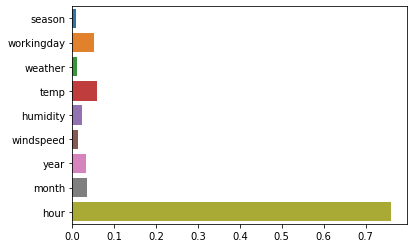

In [128]:
sns.barplot(x=rf_reg.feature_importances_,y=X_train.columns)

In [122]:
xgb_reg.fit(X_train,y_train)
pred2=xgb_reg.predict(X_test)
get_eval(y_test,np.round(pred2))

[14:25:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:0.1113 / RMSE:0.4400 / MAE:0.3468


In [123]:
lgbm_reg.fit(X_train,y_train)
pred3=lgbm_reg.predict(X_test)
get_eval(y_test,np.round(pred3))

RMSLE:0.1074 / RMSE:0.4407 / MAE:0.3466


In [124]:
vo_reg=VotingRegressor([('rf',rf_reg),('xgb',xgb_reg),('lgbm',lgbm_reg)]) #always softvoting #does not fit twice after past fit #lgbm best in every metric
vo_reg.fit(X_train,y_train)
pred4=vo_reg.predict(X_test)
get_eval(y_test,np.round(pred4))

[14:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:0.1071 / RMSE:0.4354 / MAE:0.3430


#Uploading

In [125]:
test_df.drop('count',axis=1,inplace=True)
pred=vo_reg.predict(test_df)
realpred=pd.DataFrame(np.round(pred),columns=['count'])
submit_df=pd.DataFrame({'datetime':datetime,'count':realpred['count']}) 
submit_df.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,datetime,count
0,2011-01-20 00:00:00,2.0
1,2011-01-20 01:00:00,2.0
2,2011-01-20 02:00:00,1.0


In [126]:
submit_df.to_csv('/content/gdrive/MyDrive/Dataset/Lutris_Bike.csv', index = False) 

#1)Feedback
baseline : fine for a start<br>
RMSLE:0.5590 / RMSE:33.3667 / MAE:23.2740<br>
RuntimeWarning: invalid value encountered in log1p
logscaling : much better with no expm1?!!(about prediction)<br>
RMSLE:0.2411 / RMSE:1.0469 / MAE:0.8260<br>
onehotencoding : still improvement<br>
RMSLE:0.1110 / RMSE:0.4104 / MAE:0.3021<br>
outlier windspeed<br>
RMSLE:0.1107 / RMSE:0.4090 / MAE:0.3006<br>
weight control<br>
RMSLE:0.0949 / RMSE:0.3422 / MAE:0.2395

since final score is so shockingly bad, there must have been overfitting


#2)Afterwords
regression problems are mostly time series analysis anyways